In [1]:
import perceval as pcvl
from perceval import Circuit, BasicState, NoiseModel, Processor, PostSelect, pdisplay, Detector
from perceval.algorithm import Sampler
from perceval import catalog
from tqdm import tqdm  # For Jupyter notebook progress bars


/Users/Nins/Documents/CodeProjects/UQQNN/uq-qnn/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Function Prediction Using 3x3 Memristor Chip with additional input layer

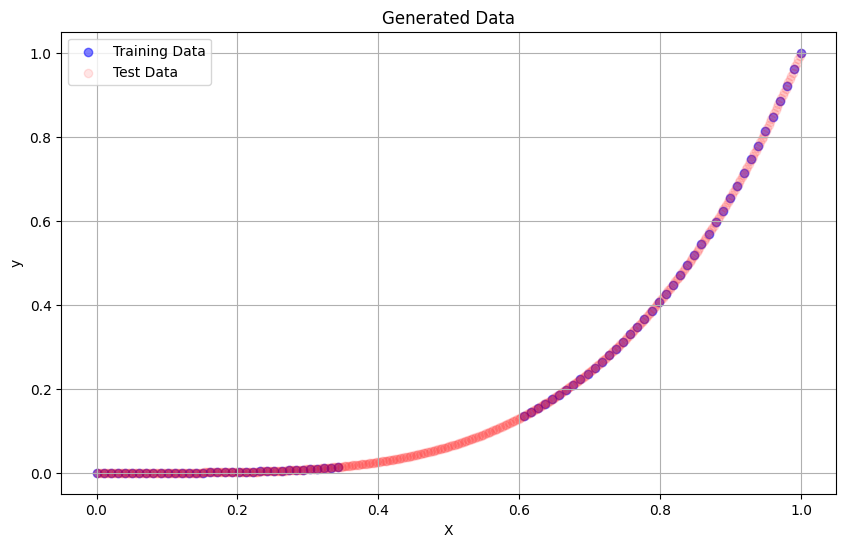

In [2]:
# Generate quartic function test data using NumPy
import numpy as np
from typing import Callable

#set the random seed for reproducibility
np.random.seed(42)

# Assuming quartic_data is defined elsewhere and works with NumPy arrays
# Example placeholder:
def quartic_data(x):
    return np.power(x, 4)

def get_data(n_data: int = 100, sigma_noise_1: float = 0.0, datafunction: Callable = quartic_data):
    """Define a function based toy regression dataset using NumPy.

    Args:
      n_data: number of data points
      sigma_noise_1: injected sigma noise on targets
      datafunction: function to compute labels based on input data

    Returns:
      train_input, train_target, test_input, test_target, label_noise
    """
    x_min = 0
    x_max = 1
    X_train = np.linspace(x_min, x_max, n_data)
    
    # split training set
    gap_start = x_min + 0.35 * (x_max - x_min)
    gap_end = x_min + 0.6 * (x_max - x_min)

    # create label noise
    # Note: For reproducibility, consider setting np.random.seed() outside this function
    # or using a np.random.Generator instance.
    noise_1 = np.random.normal(0, 1, size=n_data) * sigma_noise_1
    noise_1 = np.where(X_train > gap_end, 0.0, noise_1)  # Only add noise to the left

    # create simple function based labels data set and
    # add gaussian noise
    label_noise = noise_1
    y_train = datafunction(X_train) + label_noise

    train_idx = (X_train < gap_end) & (X_train > gap_start)

    # update X_train
    X_train = X_train[~train_idx]
    y_train = y_train[~train_idx]
    # Also filter label_noise if it's intended to correspond to the filtered X_train/y_train
    # label_noise = label_noise[~train_idx] # Uncomment if needed

    # test over the whole line
    X_test = np.linspace(x_min, x_max, 500)
    y_test = datafunction(X_test)

    return X_train, y_train, X_test, y_test, label_noise

# add uploads of encoded phases vs time measurements

# Example usage
if __name__ == "__main__":
    n_data = 100
    sigma_noise_1 = 0.0
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    
    # Plotting the data
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test Data', color='red', alpha=0.1)
    plt.title('Generated Data')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()
    

## Memristor Circuit Architecture

This function builds a 3-mode photonic circuit representing our memristor chip architecture:

1. **Input Encoding Layer**: First MZI on modes 0-1 that encodes the input value using `encoded_phase`
2. **First Processing Layer**: MZI on modes 0-1 with tunable phase `phase1`
3. **Memristor Layer**: MZI on modes 1-2 with phase determined by `memristor_phase`
4. **Output Layer**: Final MZI on modes 0-1 with tunable phase `phase3`

Each MZI consists of a beam splitter (BS), phase shifter (PS), and another beam splitter, creating a configurable interferometer structure. The architecture can be tuned through the four phase parameters to implement different functional mappings.

In [3]:
def encoding_circuit(encoded_phase):
    """Builds the encoding circuit using Perceval components."""
    # Assumes SF Rgate(phi) corresponds to pcvl PS(phi). Verify if needed.
    circuit = pcvl.Circuit(2, name="Encoding Circuit")
    # Input encoding MZI (modes 0, 1)
    circuit.add((0, 1), pcvl.BS())
    circuit.add((1,), pcvl.PS(phi=encoded_phase))
    circuit.add((0, 1), pcvl.BS())
    return circuit

def memristor_circuit(phase1, memristor_phase, phase3):
    memristor_circuit = pcvl.Circuit(3, name="Memristor Circuit")
    # First MZI (modes 0, 1)
    memristor_circuit.add((0, 1), pcvl.BS())
    memristor_circuit.add((1,), pcvl.PS(phi=phase1))
    memristor_circuit.add((0, 1), pcvl.BS())
    # Memristor MZI (modes 1, 2)
    memristor_circuit.add((1, 2), pcvl.BS())
    memristor_circuit.add((2,), pcvl.PS(phi=memristor_phase))
    memristor_circuit.add((1, 2), pcvl.BS())
    # Third MZI (modes 0, 1)
    memristor_circuit.add((0, 1), pcvl.BS())
    memristor_circuit.add((1,), pcvl.PS(phi=phase3))
    memristor_circuit.add((0, 1), pcvl.BS())
    
    return memristor_circuit


def build_circuit(phase1, memristor_phase, phase3, encoded_phase):
    """Builds the 3-mode memristor circuit using Perceval components."""
    # Assumes SF Rgate(phi) corresponds to pcvl PS(phi). Verify if needed.
    circuit = pcvl.Circuit(3, name="Full Memristor Circuit")
    # Encoding circuit
    circuit.add(0, encoding_circuit(encoded_phase))
    circuit.add(0, memristor_circuit(phase1, memristor_phase, phase3))
    
    return circuit
    

# Print the circuit
pcvl.pdisplay(build_circuit(0.1, 0.2, 0.3, 0.4), show=True, output_format=pcvl.Format.TEXT, recursive=True)

    ╔[Encoding Circuit]          ╗╔[Memristor Circuit]                                                                 ╗
    ║╭──────╮            ╭──────╮║║╭──────╮            ╭──────╮                            ╭──────╮            ╭──────╮║
0:──╫┤BS(Rx)├────────────┤BS(Rx)├╫╫┤BS(Rx)├────────────┤BS(Rx)├────────────────────────────┤BS(Rx)├────────────┤BS(Rx)├╫──:0 (depth 6)
    ║│      │            │      │║║│      │            │      │                            │      │            │      │║
    ║│      │╭──────────╮│      │║║│      │╭──────────╮│      │╭──────╮            ╭──────╮│      │╭──────────╮│      │║
1:──╫┤      ├┤PS phi=0.4├┤      ├╫╫┤      ├┤PS phi=0.1├┤      ├┤BS(Rx)├────────────┤BS(Rx)├┤      ├┤PS phi=0.3├┤      ├╫──:1 (depth 11)
    ║╰──────╯╰──────────╯╰──────╯║║╰──────╯╰──────────╯╰──────╯│      │            │      │╰──────╯╰──────────╯╰──────╯║
    ╚                            ╝║                            │      │╭──────────╮│      │                            ║
2:─

## Circuit Simulation in Perceval

To use our photonic memristor circuit for function prediction, we need to simulate its behavior using Perceval's simulation tools. Here's how we'll approach the circuit simulation:

### Simulation Components

1. **Circuit Definition**: We use our `build_circuit()` function with configurable phase parameters
2. **Input State Preparation**: We encode input using `BasicState` objects (typically |100⟩)
3. **Processor**: We use Perceval's `Processor` with the "SLOS" backend for efficient simulation
4. **Sampler**: The `Sampler` class performs the actual circuit simulation

### Simulation Process

1. The processor takes our circuit and input state
2. The sampler runs the simulation multiple times (e.g., 1000 shots)
3. We analyze the output probability distribution across the photonic modes
4. Post-selection allows us to focus on specific output states (|001⟩, |010⟩)

### Results Analysis

We'll extract probabilities for specific output states which serve as our function prediction output. By tuning the circuit parameters (`phase1`, `memristor_phase`, `phase3`), we can optimize the circuit's ability to predict our target function.

### Noise 

Perceval allows for noise simulation for every component within the circuit. 
TODO

In the next cell, we demonstrate how to run a complete simulation of our circuit.

In [4]:
# Write a short example of how to use the circuit
def run_circuit_example():
    # Example parameters
    phase1 = 0.1
    memristor_phase = 0.2
    phase3 = 0.3
    encoded_phase = 0.4

    # Build the circuit
    circuit = build_circuit(phase1, memristor_phase, phase3, encoded_phase)

    # Create a basic state (input state)
    input_state = BasicState([1, 0, 0])  # Example input state
    
    # Define output states
    state_001 = pcvl.BasicState([0, 0, 1])
    state_010 = pcvl.BasicState([0, 1, 0])
    
    # Create a processor
    proc = pcvl.Processor("SLOS", circuit)
    
    # Run the circuit with the input state
    proc.with_input(input_state)
    
    # Sample the circuit
    sampler = Sampler(proc)
    counts = sampler.sample_count(1000)  # Sample 1000 times
    probs = sampler.probs(100)
    
    print(counts['results'], probs['results'])
    
    # Post-select state_001 and state_010
    print("Post-selecting states...")
    print("State 001:", probs['results'][state_001])
    print("State 010:", probs['results'][state_010])
    

# Run the example
if __name__ == "__main__":
    run_circuit_example()
    
    

{
  |0,0,1>: 21
  |0,1,0>: 963
  |1,0,0>: 16
} {
  |1,0,0>: 0.022485859184559975
  |0,1,0>: 0.955404959532581
  |0,0,1>: 0.02210918128285909
}
Post-selecting states...
State 001: 0.02210918128285909
State 010: 0.955404959532581


## Circuit Usage for Function Prediction

The memristor circuit we've built can be used to predict complex functions like our quartic test function. Here's how the prediction process works:

1. **Input Encoding**: We encode input values (x) from our dataset into the `encoded_phase` parameter of the input MZI
2. **Circuit Configuration**: The circuit is configured with three tunable parameters:
    - `phase1`: First processing layer phase
    - `memristor_phase`: Central memristor layer phase
    - `phase3`: Output layer phase

3. **Prediction Process**:
    - For each input x, we set the `encoded_phase` parameter
    - The photonic circuit processes this input through its layered architecture
    - We measure the output photon distribution across the three modes
    - Specific output states (e.g., |001⟩ or |010⟩) correspond to predicted y-values

4. **Training**: The phases can be optimized to minimize prediction error on the training data
    - We'll compare circuit output probabilities with expected function values
    - Parameters are adjusted using optimization algorithms

The circuit effectively implements a complex nonlinear transformation that can approximate our target function through proper parameter tuning.

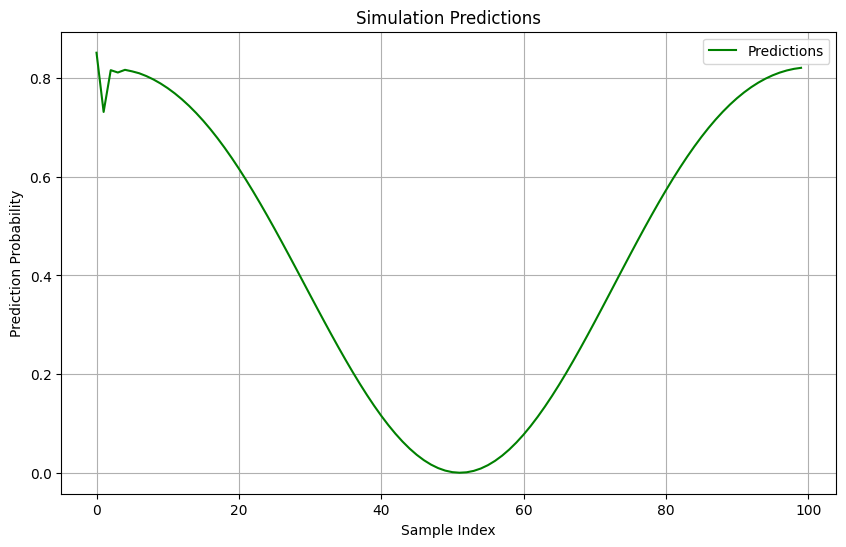

In [5]:
def run_simulation_sequence(params, encoded_phases_all, memory_depth, plot_circuit=False):
    """Runs the simulation over the sequence, updating memory."""
    phase1, phase3, memristor_weight = params
    num_samples = len(encoded_phases_all)

    memory_p1 = np.zeros(memory_depth, dtype=np.float64)
    memory_p2 = np.zeros(memory_depth, dtype=np.float64)

    predictions_001 = np.zeros(num_samples, dtype=np.float64)
    # predictions_010 = np.zeros(num_samples, dtype=np.float64) # Only needed internally

    backend = "SLOS"  # Efficient backend for Fock states
    input_state = pcvl.BasicState([0, 1, 0])
    state_001 = pcvl.BasicState([0, 0, 1])
    state_010 = pcvl.BasicState([0, 1, 0])


    # for i in tqdm(range(num_samples), desc='Running circuit simulation'):
    for i in range(num_samples):
        time_step = i % memory_depth

        if i == 0:
            memristor_phase = np.pi / 4.0 # acos(sqrt(0.5))
        else:
            # Calculate memristor phase based on memory
            mem_term1 = np.sum(memory_p1) / memory_depth
            mem_term2 = memristor_weight * np.sum(memory_p2) / memory_depth
            # Clip argument for numerical stability before sqrt and acos
            sqrt_arg = np.clip(mem_term1 + mem_term2, 1e-9, 1.0 - 1e-9)
            memristor_phase = np.arccos(np.sqrt(sqrt_arg))

        circuit = build_circuit(phase1, memristor_phase, phase3, encoded_phases_all[i])
        
        if plot_circuit:
            pcvl.pdisplay(circuit, show=True, output_format=pcvl.Format.TEXT, recursive=True)
            
        # Create a processor
        proc = pcvl.Processor(backend, circuit)
        proc.with_input(input_state)
        
        sampler = Sampler(proc)
        counts = sampler.sample_count(1000)
        probs = sampler.probs(1000)

        prob_state_001 = probs['results'].get(state_001, 0.0)
        prob_state_010 = probs['results'].get(state_010, 0.0)

        predictions_001[i] = prob_state_001
        # predictions_010[i] = prob_state_010 # Store if needed outside

        # Update memory
        memory_p1[time_step] = prob_state_010
        memory_p2[time_step] = prob_state_001

    # Return only the prediction needed for loss calculation
    return predictions_001

# Example usage
if __name__ == "__main__":
    # Example parameters
    params = (0.1, 0.3, 0.5)  # phase1, phase3, memristor_weight
    encoded_phases_all = np.linspace(0, 2 * np.pi, 100)  # Example encoded phases
    memory_depth = 2

    predictions = run_simulation_sequence(params, encoded_phases_all, memory_depth)
    
    # Plotting the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label='Predictions', color='green')
    plt.title('Simulation Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction Probability')
    plt.legend()
    plt.grid()
    plt.show()




## Optimization Framework for Memristor Circuit

This section implements the optimization framework for tuning the memristor circuit parameters to predict our target function:

### Key Components:

1. **Loss Function**: We use Mean Squared Error (MSE) to measure the difference between the circuit predictions and target values:
    - Calculates average squared difference between predicted and true values
    - Lower values indicate better prediction accuracy

2. **Objective Function**: Evaluates circuit performance for a given set of parameters:
    - Takes circuit parameters, encoded input phases, training labels, and memory depth
    - Runs the simulation to get predictions
    - Returns the MSE loss as a metric to minimize

3. **Parameter Initialization**:
    - `phase1`, `phase3`: Random initial phases between 0 and 2π
    - `memristor_weight`: Controls memory effect, initialized between 0.01 and 1
    - `memory_depth`: Determines how many previous states influence the current prediction

4. **Encoding Strategy**:
    - Input values are encoded as phases using `2 * np.arccos(X)` transformation
    - This maps inputs from [0,1] to phases in an appropriate range for the circuit

The framework allows us to evaluate how well different circuit configurations can approximate our target function, providing a foundation for parameter optimization in subsequent steps.

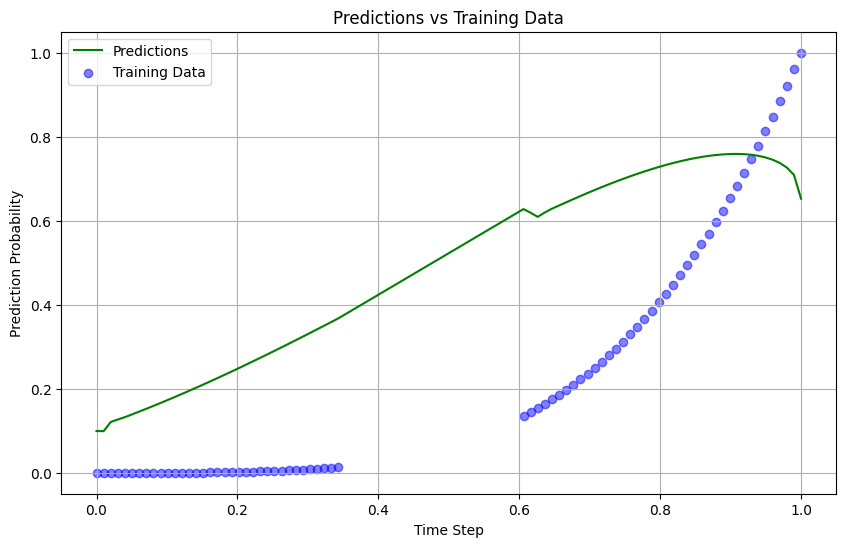

In [6]:
def mse_loss(y_true, y_pred):
    """Computes Mean Squared Error loss."""
    return np.mean(np.square(np.asarray(y_true) - np.asarray(y_pred)))

def objective_function(params, encoded_phases_all, y_train, memory_depth, plot_circuit=False):
    """Calculates the loss for a given set of parameters."""
    predictions_001 = run_simulation_sequence(params, encoded_phases_all, memory_depth, plot_circuit=plot_circuit)
    return mse_loss(y_train, predictions_001)

# Example usage of the objective function using the generated data
if __name__ == "__main__":
    n_data = 100
    sigma_noise_1 = 0.0
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    
    # Create encoded phases
    encoded_phases = 2 * np.arccos(X_train)
    num_samples = len(encoded_phases)
    
    # Initialize phases in [0, 2π]
    phase1 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32)
    phase3 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32)

    # Initialize memristor weight in [0.01, 1]
    memristor_weight = np.clip(np.random.uniform(0.01, 1), 0.01, 1).astype(np.float32)
    
    params = (phase1, phase3, memristor_weight)
    
    # Set memory depth
    memory_depth = 2
    
    # Run the objective function
    predictions = run_simulation_sequence(params, encoded_phases, memory_depth)
    
    # Calculate loss
    loss = objective_function(params, encoded_phases, y_train, memory_depth)
    
    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(X_train, predictions, label='Predictions', color='green')
    plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
    plt.title('Predictions vs Training Data')
    plt.xlabel('Time Step')
    plt.ylabel('Prediction Probability')
    plt.legend()
    plt.grid()
    plt.show()


## Gradient Computation Methods for Circuit Optimization

This section implements two complementary gradient computation methods for optimizing our memristor circuit:

### 1. Photonic Parameter Shift Rule (PSR)

The `photonic_psr_coeffs()` function implements an efficient gradient estimation technique specifically designed for phase parameters in photonic systems:

- Uses `n_photons` to determine the number of circuit evaluations
- Generates a set of shift angles and complex coefficients for accurate gradient approximation
- Provides more accurate gradient estimates than finite differences for periodic parameters
- Leverages Fast Fourier Transform (FFT) for efficient computation
- Particularly well-suited for phase parameters in our circuit

### 2. Hybrid Gradient Computation

The `compute_gradients_photonic_generic()` function combines PSR with finite differences:

- Applies PSR for phase parameters (specified by `phase_indices`)
- Uses traditional finite differences for non-phase parameters
- Handles different photon numbers for each phase parameter
- Provides gradients for all parameters in a single function call

This hybrid approach gives us the best of both worlds:
- More accurate gradient estimates for phase parameters using PSR 
- Computational efficiency by using appropriate methods for different parameter types
- Flexibility to use different numbers of photons for different phases

These gradient computation methods form the foundation for optimization algorithms to efficiently tune our circuit parameters for improved function prediction performance.

In [7]:
print(np.arange(1, 4))

[1 2 3]


In [8]:
def photonic_psr_coeffs(n_photons):
    """Compute PSR shift angles and coefficients for given photon number."""
    P = 2 * n_photons
    shifts = np.array([2 * np.pi * p / (2 * n_photons + 1) for p in range(1, P + 1)])
    gradient_vec = 1j * np.concatenate((np.arange(1, n_photons + 1), -np.arange(n_photons, 0, -1)))
    cp = np.fft.ifft(np.concatenate(([0], gradient_vec)))  # remove c0
    return shifts, cp[1:]

def compute_gradients_photonic_generic(params, encoded_phases_all, y_train, memory_depth,
                                       phase_indices, n_photons_per_phase, epsilon=1e-7):
    """
    Compute gradient vector using:
    - Photonic PSR for parameters at phase_indices
    - Finite differences for others
    Inputs:
        params: array-like of all parameters
        phase_indices: list of indices of params that are photonic phases
        n_photons_per_phase: list of photon counts (same length as phase_indices)
    """
    params = np.asarray(params)
    grads = np.zeros_like(params, dtype=np.float64)

    # print("Computing PSR gradients for phase parameters:")
    # for i, idx in enumerate(tqdm(phase_indices, desc="Processing phase parameters")):
    for i, idx in enumerate(phase_indices):
        n_photons = n_photons_per_phase[i]
        shifts, cp = photonic_psr_coeffs(n_photons)
        grad = 0.0
        
        # for shift, c in tqdm(zip(shifts, cp), desc=f"Parameter {idx} shifts", leave=False):
        for shift, c in zip(shifts, cp):
            shifted_params = params.copy()
            shifted_params[idx] += shift
            loss = objective_function(shifted_params, encoded_phases_all, y_train, memory_depth)
            grad += c * loss
            
        grads[idx] = grad.real

    # Finite differences for the rest
    all_indices = set(range(len(params)))
    finite_diff_indices = all_indices - set(phase_indices)
    
    # print("\nComputing finite difference gradients for non-phase parameters:")
    # for idx in tqdm(finite_diff_indices, desc="Processing non-phase parameters"):
    for idx in finite_diff_indices:
        params_plus = params.copy()
        params_minus = params.copy()
        params_plus[idx] += epsilon
        params_minus[idx] -= epsilon

        # Optional clipping for bounded parameters
        params_plus[idx] = np.clip(params_plus[idx], 0.01, 1.0)
        params_minus[idx] = np.clip(params_minus[idx], 0.01, 1.0)

        # for finite differences you need to do this parameter wise and the gradient is computed per paramter
        
        loss_plus = objective_function(params_plus, encoded_phases_all, y_train, memory_depth)
        loss_minus = objective_function(params_minus, encoded_phases_all, y_train, memory_depth)
        grads[idx] = (loss_plus - loss_minus) / (2 * epsilon)

    return grads

# Example usage of the gradient computation function
if __name__ == "__main__":
    n_data = 100
    sigma_noise_1 = 0.1
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    
    # Create encoded phases
    encoded_phases = 2 * np.arccos(X_train)
    num_samples = len(encoded_phases)
    
    # Initialize phases in [0, 2π]
    phase1 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32)
    phase3 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32).astype(np.float32)

    # Initialize memristor weight in [0.01, 1]
    memristor_weight = np.clip(np.random.uniform(0.01, 1), 0.01, 1).astype(np.float32)
    
    params = (phase1, phase3, memristor_weight)
    
    # Set memory depth
    memory_depth = 2
    
    # Define phase indices and photon counts
    phase_indices = [0, 2]  # Example indices for phase1 and memristor_weight
    n_photons_per_phase = [5, 10]  # Example photon counts for each phase
    
    # Compute gradients
    gradients = compute_gradients_photonic_generic(params, encoded_phases,
                                                   y_train, memory_depth,
                                                   phase_indices,
                                                   n_photons_per_phase)
    
    print("Computed gradients:", gradients)

Computed gradients: [-0.17823024  0.          0.10842087]


## Gradient-Based Optimization for Memristor Circuit Training

This section implements a gradient-based optimization strategy to train our memristor circuit for function prediction:

### Training Process Overview

1. **Parameter Initialization**:
    - `phase1`, `phase3`: Random phase values between 0 and 2π
    - `memristor_weight`: Memory influence factor between 0.01 and 1.0

2. **Gradient Descent Optimization**:
    - The `train_memristor_circuit()` function implements mini-batch gradient descent
    - Uses our hybrid gradient computation method combining PSR and finite differences
    - Updates parameters iteratively: θ = θ - learning_rate * ∇θ
    - Applies constraints after each update to maintain valid parameter ranges

3. **Key Hyperparameters**:
    - `learning_rate`: Controls step size during optimization (default: 0.01)
    - `num_epochs`: Number of complete passes through the training data
    - `memory_depth`: Historical context used by the memristor (default: 2)
    - `phase_indices`: Identifies which parameters are phases (for PSR gradient method)
    - `n_photons_per_phase`: Controls accuracy of photonic gradient estimation

4. **Convergence Monitoring**:
    - Loss is tracked across epochs to monitor training progress
    - Final model evaluation on both training and test data
    - Visualization of training curves and prediction results

The optimization process aims to find parameter values that minimize the mean squared error between circuit predictions and target function values, enabling our photonic memristor circuit to effectively approximate complex functions.

Circuit structure:
    ╔[Encoding Circuit]          ╗╔[Memristor Circuit]                                                                 ╗
    ║╭──────╮            ╭──────╮║║╭──────╮            ╭──────╮                            ╭──────╮            ╭──────╮║
0:──╫┤BS(Rx)├────────────┤BS(Rx)├╫╫┤BS(Rx)├────────────┤BS(Rx)├────────────────────────────┤BS(Rx)├────────────┤BS(Rx)├╫──:0 (depth 6)
    ║│      │            │      │║║│      │            │      │                            │      │            │      │║
    ║│      │╭──────────╮│      │║║│      │╭──────────╮│      │╭──────╮            ╭──────╮│      │╭──────────╮│      │║
1:──╫┤      ├┤PS phi=0.4├┤      ├╫╫┤      ├┤PS phi=0.1├┤      ├┤BS(Rx)├────────────┤BS(Rx)├┤      ├┤PS phi=0.3├┤      ├╫──:1 (depth 11)
    ║╰──────╯╰──────────╯╰──────╯║║╰──────╯╰──────────╯╰──────╯│      │            │      │╰──────╯╰──────────╯╰──────╯║
    ╚                            ╝║                            │      │╭──────────╮│      │              

Training: 100%|██████| 30/30 [00:43<00:00,  1.45s/it, loss=0.231716, p0=2.5950, p1=5.9678, w=0.0100]



Training completed. Final loss: 0.231979


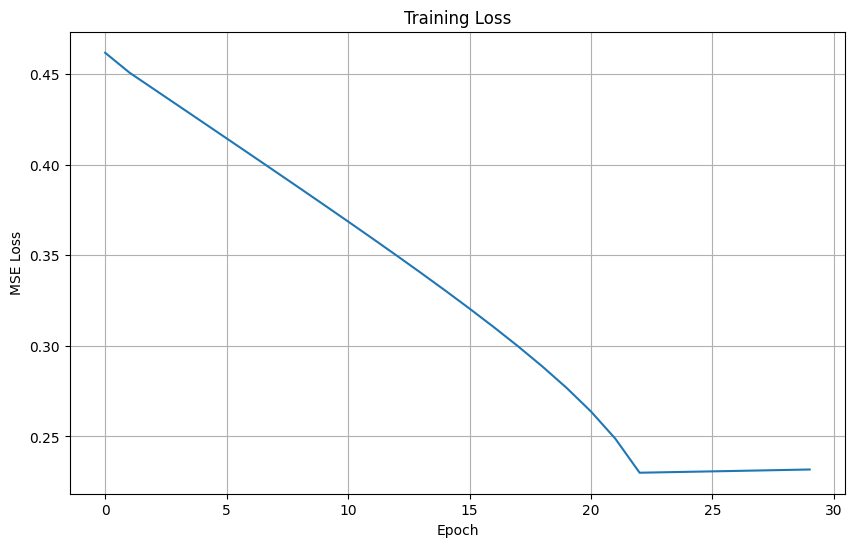

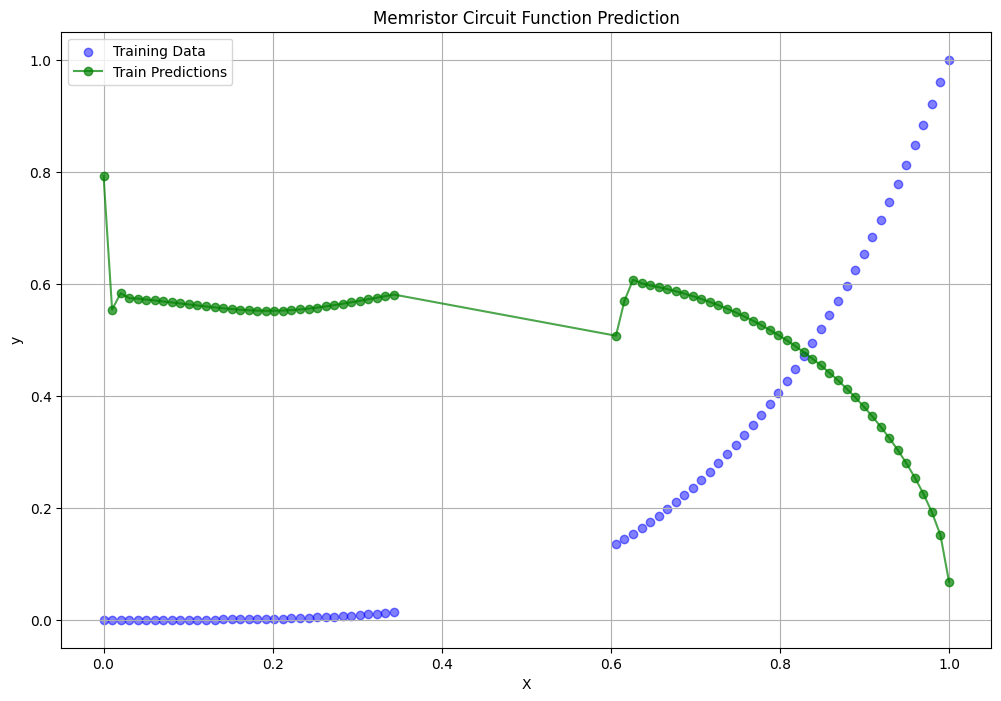

In [9]:
def train_memristor_circuit(X_train, y_train, memory_depth=2, 
                            learning_rate=0.01, num_epochs=50,
                            phase_indices=[0, 1], n_photons_per_phase=[1, 1]):
    """
    Train the memristor circuit using gradient descent.
    
    Args:
        X_train: Training input data
        y_train: Training target data  
        memory_depth: Memory depth for the memristor circuit
        learning_rate: Learning rate for gradient descent
        num_epochs: Number of training epochs
        phase_indices: Indices of parameters that are phases (for PSR)
        n_photons_per_phase: Number of photons per phase parameter
    
    Returns:
        params: Optimized parameters
        losses: List of losses during training
    """
    
    np.random.seed(42)  # For reproducibility
    
    # Initialize parameters
    phase1 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32)
    phase3 = np.clip(np.random.uniform(0.01, 1) * 2 * np.pi, 0, 2 * np.pi).astype(np.float32)
    memristor_weight = np.clip(np.random.uniform(0.01, 1), 0.01, 1).astype(np.float32)
    
    params = np.array([phase1, phase3, memristor_weight])
    encoded_phases = 2 * np.arccos(X_train)
    
    # Store losses for plotting
    losses = []
    
    # Main training loop with progress bar
    print(f"Starting training for {num_epochs} epochs:")
    with tqdm(range(num_epochs), desc="Training", ncols=100) as pbar:
        for epoch in pbar:
            # Forward pass
            current_loss = objective_function(params, encoded_phases, y_train, memory_depth)
            losses.append(current_loss)
            
            # Display current status
            pbar.set_postfix({
            'loss': f"{current_loss:.6f}",
            'p0': f"{params[0]:.4f}",
            'p1': f"{params[1]:.4f}",
            'w': f"{params[2]:.4f}"
            })
            
            # Compute gradients
            grads = compute_gradients_photonic_generic(
                params, encoded_phases, y_train, memory_depth,
                phase_indices, n_photons_per_phase
            )
            
            # Update parameters using gradient descent
            params = params - learning_rate * grads
            
            # Apply constraints to parameters
            # Phases should be in [0, 2π]
            params[0] = params[0] % (2 * np.pi)  # phase1
            params[1] = params[1] % (2 * np.pi)  # phase3
            # Memristor weight should be in [0.01, 1]
            params[2] = np.clip(params[2], 0.01, 1.0)  # memristor_weight
    
    # Final evaluation
    final_loss = objective_function(params, encoded_phases, y_train, memory_depth)
    print(f"\nTraining completed. Final loss: {final_loss:.6f}")
    
    return params, losses


if __name__ == "__main__":
    # Generate data
    n_data = 100
    sigma_noise_1 = 0.0
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    
    # Print the circuit
    print("Circuit structure:")
    pcvl.pdisplay(build_circuit(0.1, 0.2, 0.3, 0.4), show=True, output_format=pcvl.Format.TEXT, recursive=True)
    
    # Train the circuit
    optimal_params, training_losses = train_memristor_circuit(
        X_train, y_train, 
        memory_depth=2,
        learning_rate=0.1, 
        num_epochs=30,
        phase_indices=[0, 1],  # phase1 and phase3 are phases
        n_photons_per_phase=[1, 1]
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid()
    plt.show()
    
    # Generate predictions with the optimized parameters
    encoded_phases_train = 2 * np.arccos(X_train)
    encoded_phases_test = 2 * np.arccos(X_test)
    
    # Get predictions for training and test data
    train_predictions = run_simulation_sequence(optimal_params, encoded_phases_train, memory_depth=2)
    test_predictions = run_simulation_sequence(optimal_params, encoded_phases_test, memory_depth=2)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
    plt.plot(X_train, train_predictions, 'o-', label='Train Predictions', color='green', alpha=0.7)
    # plt.plot(X_test, y_test, label='True Function', color='red', alpha=0.3)
    # plt.plot(X_test, test_predictions, label='Test Predictions', color='purple', alpha=0.7)
    plt.title('Memristor Circuit Function Prediction')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

Use Scipy to optimize

In [10]:
from scipy.optimize import minimize

def objective_wrapped(params, encoded_phases, y_train, memory_depth):
    return objective_function(params, encoded_phases, y_train, memory_depth)

def train_with_scipy_optimizer(X_train, y_train, memory_depth=2):
    encoded_phases = 2 * np.arccos(X_train)
    
    # Initial parameters: [phase1, phase3, memristor_weight]
    init_params = np.array([
        np.random.uniform(0, 2 * np.pi),
        np.random.uniform(0, 2 * np.pi),
        np.random.uniform(0.01, 1)
    ])
    
    # Bounds: phases in [0, 2π], weight in [0.01, 1]
    bounds = [(0, 2*np.pi), (0, 2*np.pi), (0.01, 1.0)]
    
    result = minimize(
        objective_wrapped,
        init_params,
        args=(encoded_phases, y_train, memory_depth),
        method='L-BFGS-B',  # or 'Powell', 'Nelder-Mead' if gradient-free
        bounds=bounds,
        options={'disp': True, 'maxiter': 100}
    )
    
    return result.x, result.fun

Now we run the scipy loop and plot the results.

Circuit structure:
    ╔[Encoding Circuit]          ╗╔[Memristor Circuit]                                                                 ╗
    ║╭──────╮            ╭──────╮║║╭──────╮            ╭──────╮                            ╭──────╮            ╭──────╮║
0:──╫┤BS(Rx)├────────────┤BS(Rx)├╫╫┤BS(Rx)├────────────┤BS(Rx)├────────────────────────────┤BS(Rx)├────────────┤BS(Rx)├╫──:0 (depth 6)
    ║│      │            │      │║║│      │            │      │                            │      │            │      │║
    ║│      │╭──────────╮│      │║║│      │╭──────────╮│      │╭──────╮            ╭──────╮│      │╭──────────╮│      │║
1:──╫┤      ├┤PS phi=0.4├┤      ├╫╫┤      ├┤PS phi=0.1├┤      ├┤BS(Rx)├────────────┤BS(Rx)├┤      ├┤PS phi=0.3├┤      ├╫──:1 (depth 11)
    ║╰──────╯╰──────────╯╰──────╯║║╰──────╯╰──────────╯╰──────╯│      │            │      │╰──────╯╰──────────╯╰──────╯║
    ╚                            ╝║                            │      │╭──────────╮│      │              

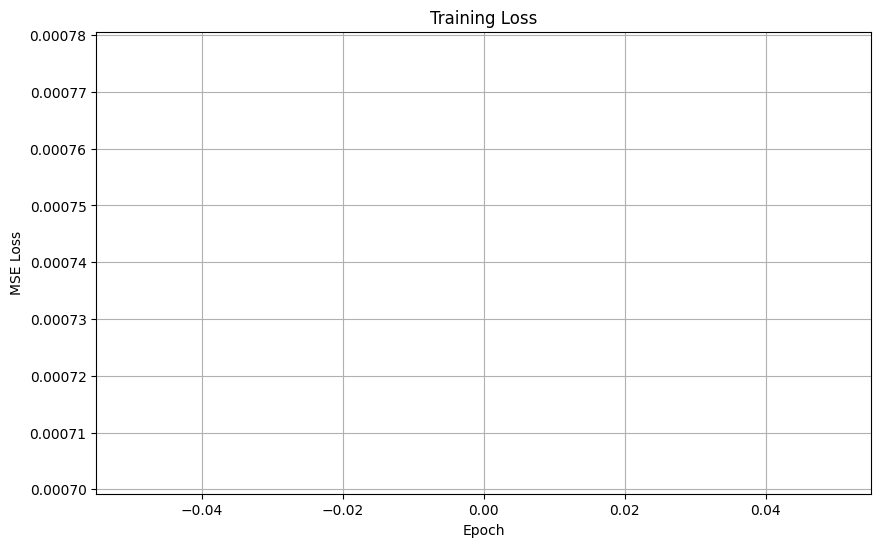

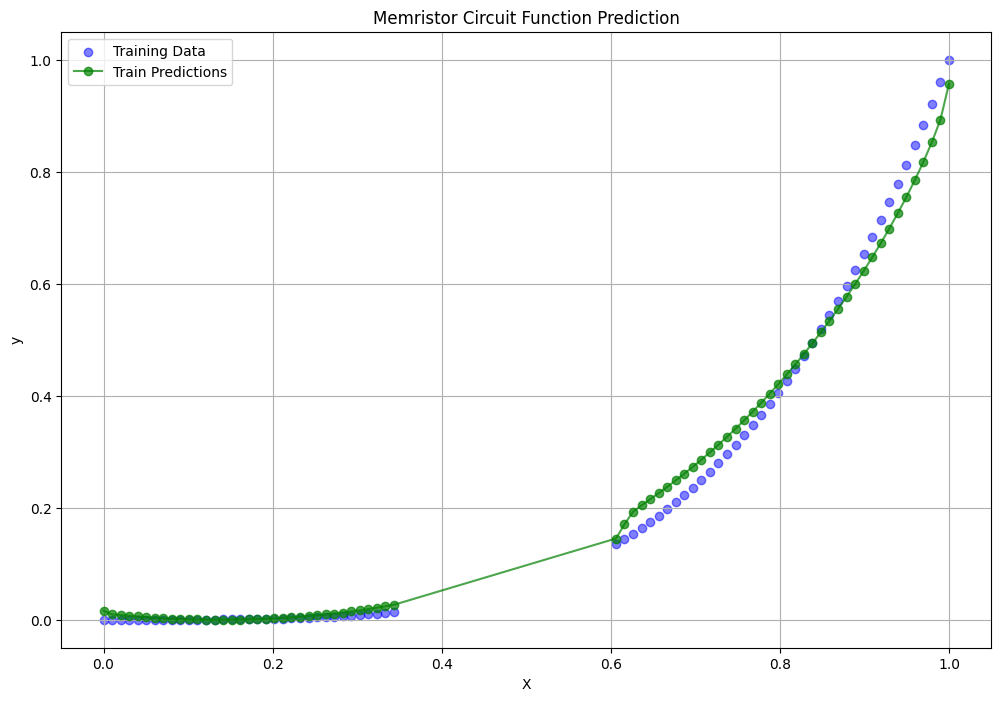

In [11]:
if __name__ == "__main__":
    # Generate data
    n_data = 100
    sigma_noise_1 = 0.0
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    
    # Print the circuit
    print("Circuit structure:")
    pcvl.pdisplay(build_circuit(0.1, 0.2, 0.3, 0.4), show=True, output_format=pcvl.Format.TEXT, recursive=True)
    
    # Train the circuit with scipy
    optimal_params, training_losses = train_with_scipy_optimizer(
        X_train, y_train, 
        memory_depth=2
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid()
    plt.show()
    
    # Generate predictions with the optimized parameters
    encoded_phases_train = 2 * np.arccos(X_train)
    encoded_phases_test = 2 * np.arccos(X_test)
    
    # Get predictions for training and test data
    train_predictions = run_simulation_sequence(optimal_params, encoded_phases_train, memory_depth=2)
    test_predictions = run_simulation_sequence(optimal_params, encoded_phases_test, memory_depth=2)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
    plt.plot(X_train, train_predictions, 'o-', label='Train Predictions', color='green', alpha=0.7)
    # plt.plot(X_test, y_test, label='True Function', color='red', alpha=0.3)
    # plt.plot(X_test, test_predictions, label='Test Predictions', color='purple', alpha=0.7)
    plt.title('Memristor Circuit Function Prediction')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

Now we want to incoporate the measurement data into our scipy training loop to optimze the parameters for continuous encoding.

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Replace these filenames with the correct paths to your pickle files.
file0 = 'data/nina_measurements0pi1-1.pkl'
file1 = 'data/nina_measurementspi-1.pkl'
file2 = 'data/nina_measurements_31_1-1.pkl'

# Load the data from the pickle files
data0 = load_pickle_data(file0)
data1 = load_pickle_data(file1)
data2 = load_pickle_data(file2)

Do $\Delta x$ uniform bins with different time bins:

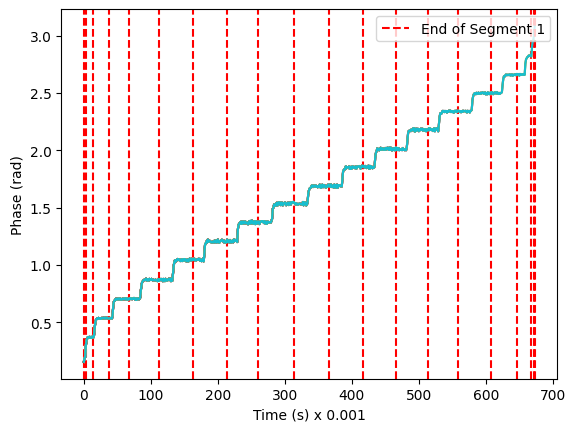

Bin Edges: [0.2 0.8]
Bin Width: 0.6000000000000001


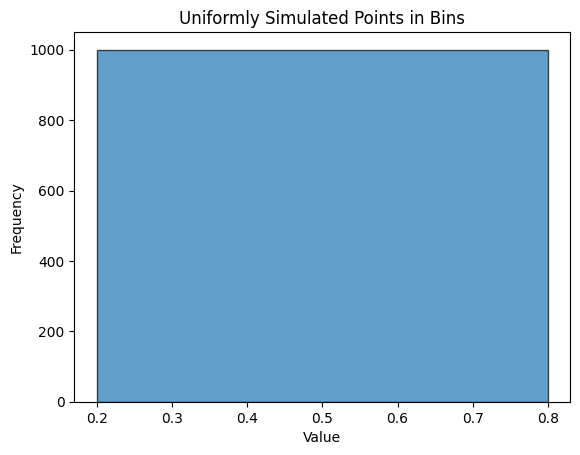

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load pickle data
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data from file2
file2 = 'data/nina_measurements_31_1-1.pkl'
data2 = load_pickle_data(file2)

# Extract relevant data
time_unit = data2[0]  # Time unit (s)
start_phases = data2[1]  # Starting phases
end_phases = data2[2]  # Final phases
normalized_powers = data2[3]  # Normalized output powers (1x60 for each measurement)

# Step 1: Store time bins for each measurement
data_time_bins = []
data_2 = []

for i in range(20):  # Loop through 20 measurements
    temp_time_bin = []
    for j in range(1, 60):  # Loop through 60 time samples per measurement
        # here data_2 should be the encoded phases in the continuous swipe
        if abs(normalized_powers[60 * i + j] - normalized_powers[60 * i + j - 1]) > 0.001:
            data_2.append(2 * np.arccos(np.sqrt(normalized_powers[60 * i + j])))
            temp_time_bin.append(2 * np.arccos(np.sqrt(normalized_powers[60 * i + j])))
    
    # Store the time bin for the current segment
    data_time_bins.append(temp_time_bin)

    # Plot the data
    plt.plot(data_2)
    
    # Add a vertical line at the end of each iteration
    plt.axvline(x=len(data_2), color='red', linestyle='--', label=f"End of Segment {i + 1}" if i == 0 else None)

# Add labels and legend
plt.xlabel("Time (s) x 0.001")
plt.ylabel("Phase (rad)")
plt.legend(loc="upper right")
plt.show()

# Step 2: Function to determine time bins for discrete classical data points
def determine_time_bins(data, a, b, max_bins=10):
    """
    Determine time bins for discrete classical data points from interval [a, b].
    Maximizes the length of bins based on the data.

    Parameters:
        data (array-like): The data points to bin.
        a (float): Start of the interval (0 <= a).
        b (float): End of the interval (b <= 1).
        max_bins (int): Maximum number of bins to consider.

    Returns:
        bin_edges (list): The edges of the bins.
        bin_width (float): The width of each bin.
    """
    if not (0 <= a < b <= 1):
        raise ValueError("Interval [a, b] must satisfy 0 <= a < b <= 1.")
    
    # Filter data points within the interval [a, b]
    data = np.array(data)
    data_in_interval = data[(data >= a) & (data <= b)]
    
    if len(data_in_interval) == 0:
        raise ValueError("No data points found in the interval [a, b].")
    
    # Determine the maximum bin width while ensuring all data points are covered
    best_bin_width = 0
    best_bin_edges = []
    
    for num_bins in range(1, max_bins + 1):
        bin_edges = np.linspace(a, b, num_bins + 1)
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Check if all data points fall within the bins
        if np.all((data_in_interval >= bin_edges[0]) & (data_in_interval <= bin_edges[-1])):
            if bin_width > best_bin_width:
                best_bin_width = bin_width
                best_bin_edges = bin_edges
    
    return best_bin_edges, best_bin_width

# Step 3: Maximize bin length based on normalized powers
normalized_powers_flat = np.array(normalized_powers).flatten()  # Flatten the 1x60 data
bin_edges, bin_width = determine_time_bins(normalized_powers_flat, a=0.2, b=0.8)

print("Bin Edges:", bin_edges)
print("Bin Width:", bin_width)

# Step 4: Simulate uniform distribution of points in bins
def simulate_uniform_points(bin_edges, num_points_per_bin=1000):
    """
    Simulate a uniform distribution of points in bins around classical data points.

    Parameters:
        bin_edges (list): The edges of the bins.
        num_points_per_bin (int): Number of uniformly sampled points per bin.

    Returns:
        simulated_points (array): Uniformly sampled points across all bins.
    """
    simulated_points = []
    for i in range(len(bin_edges) - 1):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        points = np.linspace(bin_start, bin_end, num_points_per_bin)
        simulated_points.extend(points)
    return np.array(simulated_points)

# Simulate points for the determined bins
simulated_points = simulate_uniform_points(bin_edges, num_points_per_bin=1000)

# Plot the simulated points
plt.hist(simulated_points, bins=bin_edges, edgecolor='black', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Uniformly Simulated Points in Bins")
plt.show()

In [14]:
def get_cont_swipe_data(encoded_phases, measured_phases, n_swipe: int = 20):
    """Use measurement data and data function to obtain training swipe data
    Args:
      encoded_phases: 2*arccos(X) from data X
      measured_phases: data that is measured.
    Returns:
      enc_samples: np array of dimension len(encoded_phases)x n_swipe 
                where entries are measured phase values
    """
    # assert that n_swipe is an even number such that we can divide by 2
    #assert isinstance(n_swipe/2,int)
    n_data = len(encoded_phases)
    n_meas = len(measured_phases)
    enc_samples = np.empty([n_data, n_swipe])
    n2 = int(n_swipe/2)
    for i in range(n_data):
        # worst not efficient coding, sorry, finding the measured phase index closest to the encoded phase 
        z = np.abs(encoded_phases[i]*np.ones(n_meas)-measured_phases)
        x = np.min(z)
        k = np.where(z == x)
        # for sure - or +1 is missing in the range
        for l in range(k-n2,k+n2, 1):
            # maybe you can make this better by adding some append?
            enc_samples[i,(l-k+n2)]= measured_phases[l]
    return enc_samples

Based on the above notebook cells (yikes) the measured_phases are called data_2, which we will use in the following.

In [15]:
# add objective function for fitting with measurment data or change y_pred computation from run_simulatipn_sequenmce

def mse_loss(y_true, y_pred):
    """Computes Mean Squared Error loss."""
    return np.mean(np.square(np.asarray(y_true) - np.asarray(y_pred))) # in np.asarray(y_pred) each pred should be the mean over samples run with different encoded phases around x[i]

# example what could be changed in run_simulation_sequence

def run_simulation_sequence_cont(params, encoded_phases_all, measured_phases, n_swipe, memory_depth, plot_circuit=False):
    """Runs the simulation over the sequence, updating memory."""

    # get swipe data for approximately continuous encoding simulation
    enc_samples = get_cont_swipe_data(encoded_phases_all, measured_phases, n_swipe)

    # get params
    phase1, phase3, memristor_weight = params
    num_samples = len(encoded_phases_all) # per num samples we now have n_swipe extra samples for the samples of encoded phases around the encoded point i that are passes through the circuit and averaged

    memory_p1 = np.zeros(memory_depth, dtype=np.float64)
    memory_p2 = np.zeros(memory_depth, dtype=np.float64)

    predictions_001 = np.zeros(num_samples, dtype=np.float64)
    # predictions_010 = np.zeros(num_samples, dtype=np.float64) # Only needed internally

    backend = "SLOS"  # Efficient backend for Fock states
    input_state = pcvl.BasicState([0, 1, 0])
    state_001 = pcvl.BasicState([0, 0, 1])
    state_010 = pcvl.BasicState([0, 1, 0])


    # for i in tqdm(range(num_samples), desc='Running circuit simulation'):
    for i in range(num_samples):
        # add extra for loop over s samples k in range(s) for each i in range(num_samples) such that the extra encoded phases are on the measurement diagram and within +-delta(t)/2 of the time stamp/index i
        
        time_step = i % memory_depth

        if i == 0:
            memristor_phase = np.pi / 4.0 # acos(sqrt(0.5))
        else:
            # Calculate memristor phase based on memory
            mem_term1 = np.sum(memory_p1) / memory_depth
            mem_term2 = memristor_weight * np.sum(memory_p2) / memory_depth
            # Clip argument for numerical stability before sqrt and acos
            sqrt_arg = np.clip(mem_term1 + mem_term2, 1e-9, 1.0 - 1e-9)
            memristor_phase = np.arccos(np.sqrt(sqrt_arg))

        # for sure the range is off here again
        # create emoty arrays for each i for collecting swipe predictions
        prob_state_001 = np.empty(n_swipe)
        prob_state_010 = np.empty(n_swipe)
            
        # now we do some kind of sliding window thing over measured phases to simulate the continuous swipe    
        for k in range(n_swipe):
        
            #the above for loop over s samples k in range(s) is here
            circuit = build_circuit(phase1, memristor_phase, phase3, enc_samples[i,k])
        
            if plot_circuit:
                pcvl.pdisplay(circuit, show=True, output_format=pcvl.Format.TEXT, recursive=True)
            
            # Create a processor
            proc = pcvl.Processor(backend, circuit)
            proc.with_input(input_state)
        
            # we have to map the number here to a realistic count within the swipe measurement setting
            sampler = Sampler(proc)
            counts = sampler.sample_count(1000)
            probs = sampler.probs(1000)

            # probably this perceval object is not an np.array, but it could be soon?
            prob_state_001.append(probs['results'].get(state_001, 0.0))
            prob_state_010.append(probs['results'].get(state_010, 0.0))
            

        # now we get for each i s samples of predictions and at the end of the k for-loop we should have something like predictions_001[i] = 1/s \sum_{k=0}^{s-1} prob_state_001[i,k]
        predictions_001[i] = prob_state_001.mean()
        # predictions_010[i] = prob_state_010 # Store if needed outside

        # Update memory
        # the same averaging over k happens here
        memory_p1[time_step] = prob_state_010.mean()
        memory_p2[time_step] = prob_state_001.mean()

    # Return only the prediction needed for loss calculation
    # we get the same length of pred vector (num_samples), but the entries are averages where the data measurements of the encoded phases is taken into account
    return predictions_001

def objective_function_cont(params, encoded_phases_all, y_train, measured_phases, n_swipe, memory_depth, plot_circuit=False):
    """Calculates the loss for a given set of parameters."""
    predictions_001 = run_simulation_sequence_cont(params, encoded_phases_all, measured_phases, n_swipe, memory_depth, plot_circuit=plot_circuit)
    return mse_loss(y_train, predictions_001)


In [16]:
def objective_wrapped_cont(params, encoded_phases, y_train, measured_phases, n_swipe, memory_depth):
    return objective_function_cont(params, encoded_phases, y_train, measured_phases, n_swipe, memory_depth)

def train_with_scipy_optimizer_cont(X_train, y_train, measured_phases, n_swipe, memory_depth=2):
    encoded_phases = 2 * np.arccos(X_train)
    
    # Initial parameters: [phase1, phase3, memristor_weight]
    init_params = np.array([
        np.random.uniform(0, 2 * np.pi),
        np.random.uniform(0, 2 * np.pi),
        np.random.uniform(0.01, 1)
    ])
    
    # Bounds: phases in [0, 2π], weight in [0.01, 1]
    bounds = [(0, 2*np.pi), (0, 2*np.pi), (0.01, 1.0)]
    
    result = minimize(
        objective_wrapped_cont,
        init_params,
        args=(encoded_phases, y_train, measured_phases, n_swipe, memory_depth),
        method='L-BFGS-B',  # or 'Powell', 'Nelder-Mead' if gradient-free
        bounds=bounds,
        options={'disp': True, 'maxiter': 100}
    )
    
    return result.x, result.fun

In [17]:
if __name__ == "__main__":
    # Generate data
    n_data = 100
    sigma_noise_1 = 0.0
    X_train, y_train, X_test, y_test, label_noise = get_data(n_data, sigma_noise_1)
    n_swipe = 20
    measured_phases = data_2
    
    # Print the circuit
    print("Circuit structure:")
    pcvl.pdisplay(build_circuit(0.1, 0.2, 0.3, 0.4), show=True, output_format=pcvl.Format.TEXT, recursive=True)
    
    # Train the circuit with scipy
    optimal_params, training_losses = train_with_scipy_optimizer_cont(
        X_train, y_train, 
        measured_phases, n_swipe,
        memory_depth=2
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid()
    plt.show()
    
    # Generate predictions with the optimized parameters
    encoded_phases_train = 2 * np.arccos(X_train)
    encoded_phases_test = 2 * np.arccos(X_test)
    
    # Get predictions for training and test data
    train_predictions = run_simulation_sequence_cont(optimal_params, encoded_phases_train, measured_phases, n_swipe, memory_depth=2)
    test_predictions = run_simulation_sequence_cont(optimal_params, encoded_phases_test, measured_phases, n_swipe, memory_depth=2)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=0.5)
    plt.plot(X_train, train_predictions, 'o-', label='Train Predictions', color='green', alpha=0.7)
    # plt.plot(X_test, y_test, label='True Function', color='red', alpha=0.3)
    # plt.plot(X_test, test_predictions, label='Test Predictions', color='purple', alpha=0.7)
    plt.title('Memristor Circuit Function Prediction')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

Circuit structure:
    ╔[Encoding Circuit]          ╗╔[Memristor Circuit]                                                                 ╗
    ║╭──────╮            ╭──────╮║║╭──────╮            ╭──────╮                            ╭──────╮            ╭──────╮║
0:──╫┤BS(Rx)├────────────┤BS(Rx)├╫╫┤BS(Rx)├────────────┤BS(Rx)├────────────────────────────┤BS(Rx)├────────────┤BS(Rx)├╫──:0 (depth 6)
    ║│      │            │      │║║│      │            │      │                            │      │            │      │║
    ║│      │╭──────────╮│      │║║│      │╭──────────╮│      │╭──────╮            ╭──────╮│      │╭──────────╮│      │║
1:──╫┤      ├┤PS phi=0.4├┤      ├╫╫┤      ├┤PS phi=0.1├┤      ├┤BS(Rx)├────────────┤BS(Rx)├┤      ├┤PS phi=0.3├┤      ├╫──:1 (depth 11)
    ║╰──────╯╰──────────╯╰──────╯║║╰──────╯╰──────────╯╰──────╯│      │            │      │╰──────╯╰──────────╯╰──────╯║
    ╚                            ╝║                            │      │╭──────────╮│      │              

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'